# Tugas 4 Crawling Data Berita

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

Mengambil data pada web detik.com

In [2]:
def get_data(url, category):
  data_page = requests.get(url)
  print(url)
  if data_page.status_code == 200:
    data_berita = []
    container = BeautifulSoup(data_page.content, 'html.parser')
    container_page = container.find('div', class_='detail__body-text itp_bodycontent')
    data = container_page.find_all('p')
    judul_berita = container.find('h1', class_='detail__title').text.strip()
    tanggal_berita = container.find('div', class_='detail__date').text.strip()

    data_content = ''.strip()
    for i in data:
      if  'ADVERTISEMENT' not in i.text.strip() and  'SCROLL TO RESUME CONTENT' not in i.text.strip() and i.find('div', class_='detail__multiple') == None:
        data_content += i.text.strip() + ' '

    data_berita.append(judul_berita)
    data_berita.append(tanggal_berita)
    data_berita.append(data_content)
    data_berita.append(category)

    return data_berita

Mengambil content pada web detik.com

In [3]:
def get_content (url, category):
  menu_page = requests.get(url)
  if menu_page.status_code == 200:
    content = BeautifulSoup(menu_page.content, 'html.parser')
    content_page = content.find('div', class_='grid-row list-content')
    container_content = content_page.find_all('div', class_='media media--left media--image-radius block-link')

    # Untuk menyimpan url content
    data_content = []
    for c in container_content:
      link_content = c.find('a', class_='media__link')
      subtitle = c.find('h2', class_='media__subtitle')
      if subtitle == None and '20.detik' not in str(link_content) and 'intermeso' not in str(link_content) and 'foto' not in str(link_content):
        data_berita = get_data(link_content.get('href'), category)
        data_content.append(data_berita)

    next_page = content.find_all('a', class_='pagination__item')
    for i in next_page:
      if 'Next' == i.text.strip():
        return (data_content, i.get('href'))

Mengambil judul dan URL pada web detik.com

In [4]:
def scraping_detik_news(url='https://news.detik.com/indeks', num_content = 1, category= ['Edu']):
  response = requests.get(url)

  # Untuk mengecek respon url dan mencari menu sidebar
  if response.status_code == 200:
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    menu = soup.find('nav', class_='static-nav')
    link_menu = menu.find_all('a')
    # Untuk menyimpan url navbar
    save_link_navbar = []
    for link in link_menu:
      if 'travel' not in link.get('href') and 'wolipop' not in link.get('href'):
        save_link_navbar.append([link.find('div').text.strip(), link.get('href')])

    # Untuk mengecek respon url dan mencari link content
    data_semua_berita = []
    for nav in save_link_navbar:
      if nav[0] in category:
        data_berita, next_page = get_content(nav[1], nav[0])
        data_semua_berita += data_berita


        next_page_more = next_page
        for i in range(num_content-1):
          more_content, next_page_more = get_content(next_page_more, nav[0])
          data_semua_berita += more_content

    df = pd.DataFrame(data_semua_berita, columns=['Judul', 'Tanggal', 'Artikel', 'Category'])
    df.to_csv('Data Berita Detik.csv', index=False)
    print(f'Data Berhasil Di Simpan dengan Jumlah {len(data_semua_berita)}')

Memanggil fungsi scraping_detik_news()

In [5]:
scraping_detik_news(url='https://news.detik.com/indeks', num_content=1, category=['Edu'])

https://www.detik.com/edu/perguruan-tinggi/d-7075243/jadwal-survei-kebinekaan-dan-vcat-pertukaran-mahasiswa-merdeka-4-catat
https://www.detik.com/edu/sekolah/d-7075929/studi-arkas-kurangi-beban-guru-kepsek-yang-double-job
https://www.detik.com/edu/sekolah/d-7075329/dorong-ranking-pisa-indonesia-kemenag-latih-54-ribu-guru-madrasah
https://www.detik.com/edu/edutainment/d-7075939/sah-budaya-sehat-jamu-indonesia-masuk-warisan-budaya-takbenda-unesco
https://www.detik.com/edu/sekolah/d-7075877/menurut-survei-pisa-2022-siswa-kurang-mampu-ri-jago-matematika
https://www.detik.com/edu/sekolah/d-7075808/survei-pisa-2022-siswa-ri-perempuan-ungguli-laki-laki-dalam-membaca-matematika
https://www.detik.com/edu/sekolah/d-7075675/ganti-menteri-nadiem-optimis-platform-teknologi-pendidikan-ri-tetap-jalan
https://www.detik.com/edu/detikpedia/d-7075351/ketahui-apa-itu-pisa-program-evaluasi-sistem-pendidikan-negara
https://www.detik.com/edu/sekolah/d-7075431/studi-rapor-pendidikan-bantu-pendidikan-ri-begini

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
import pandas as pd
import numpy as np
import nltk
import re
import csv

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df = pd.read_csv('/content/Data Berita Detik.csv')
df

,Judul,Tanggal,Artikel,Category
0,Jadwal Survei Kebinekaan dan VCAT Pertukaran M...,"Rabu, 06 Des 2023 20:30 WIB",Pertukaran Mahasiswa Merdeka 4 (PMM 4) memasuk...,Edu
1,Studi: ARKAS Kurangi Beban Guru & Kepsek yang ...,"Rabu, 06 Des 2023 20:00 WIB",Aplikasi Rencana Kegiatan dan Anggaran Sekolah...,Edu
2,"Dorong Ranking PISA Indonesia, Kemenag Latih 5...","Rabu, 06 Des 2023 19:30 WIB",Pusdiklat Tenaga Teknis Pendidikan dan Keagama...,Edu
3,Sah! Budaya Sehat Jamu Indonesia Masuk Warisan...,"Rabu, 06 Des 2023 19:02 WIB",Jamu Indonesia resmi masuk Warisan Budaya Takb...,Edu
4,"Menurut Survei PISA 2022, Siswa Kurang Mampu R...","Rabu, 06 Des 2023 18:30 WIB",Organization for Economic Co-operation and Dev...,Edu
5,Survei PISA 2022: Siswa RI Perempuan Ungguli L...,"Rabu, 06 Des 2023 18:00 WIB",Berdasarkan survei Programme for International...,Edu
6,"Ganti Menteri, Nadiem Optimis Platform Teknolo...","Rabu, 06 Des 2023 17:30 WIB","Studi Oliver Wyman mendapati, intervensi tekno...",Edu
7,"Ketahui Apa Itu PISA, Program Evaluasi Sistem ...","Rabu, 06 Des 2023 17:00 WIB",Programme for International Student Assessment...,Edu
8,"Studi: Rapor Pendidikan Bantu Pendidikan RI, B...","Rabu, 06 Des 2023 16:30 WIB",Intervensi teknologi Kemendikbudristek dinilai...,Edu
9,"Kemenkeu Buka Posisi Magang Merdeka Batch 6, I...","Rabu, 06 Des 2023 16:00 WIB",Kementerian Keuangan (Kemenkeu) buka kesempata...,Edu


In [8]:
def cleaning(text):
    # Remove non-alphabetic characters (letters, spaces, and punctuation other than periods)
    text = re.sub(r'[^a-zA-Z\s.,]', '', text).strip()
    return text

df['Cleaning'] = df['Artikel'].apply(cleaning)
df['Cleaning']

0     Pertukaran Mahasiswa Merdeka  PMM  memasuki pr...
1     Aplikasi Rencana Kegiatan dan Anggaran Sekolah...
2     Pusdiklat Tenaga Teknis Pendidikan dan Keagama...
3     Jamu Indonesia resmi masuk Warisan Budaya Takb...
4     Organization for Economic Cooperation and Deve...
5     Berdasarkan survei Programme for International...
6     Studi Oliver Wyman mendapati, intervensi tekno...
7     Programme for International Student Assessment...
8     Intervensi teknologi Kemendikbudristek dinilai...
9     Kementerian Keuangan Kemenkeu buka kesempatan ...
10    Mengembangkan cara berpikir matematis pada ana...
11    Pendidikan Pancasila merupakan salah satu mata...
12    Menteri Pendayagunaan Aparatur Negara dan Refo...
13    Kemendikbudristek telah merilis hasil studi PI...
14    Penilaian Akhir Semester PAS akan siswa hadapi...
15    Sebuah citra satelit telah berhasil menangkap ...
16    Detikers, pernahkah kamu melihat telur ayam ya...
17    Seleksi Nasional Penerimaan Mahasiswa Baru

In [9]:
from nltk.tokenize import sent_tokenize
# Fungsi untuk mengekstrak artikel menjadi kalimat
def extract_sentences(article):
    sentences = sent_tokenize(article)
    return sentences

# Menerapkan fungsi extract_sentences ke setiap baris dalam kolom 'artikel'
df['Kalimat'] = df['Cleaning'].apply(extract_sentences)
df['Kalimat']

0     [Pertukaran Mahasiswa Merdeka  PMM  memasuki p...
1     [Aplikasi Rencana Kegiatan dan Anggaran Sekola...
2     [Pusdiklat Tenaga Teknis Pendidikan dan Keagam...
3     [Jamu Indonesia resmi masuk Warisan Budaya Tak...
4     [Organization for Economic Cooperation and Dev...
5     [Berdasarkan survei Programme for Internationa...
6     [Studi Oliver Wyman mendapati, intervensi tekn...
7     [Programme for International Student Assessmen...
8     [Intervensi teknologi Kemendikbudristek dinila...
9     [Kementerian Keuangan Kemenkeu buka kesempatan...
10    [Mengembangkan cara berpikir matematis pada an...
11    [Pendidikan Pancasila merupakan salah satu mat...
12    [Menteri Pendayagunaan Aparatur Negara dan Ref...
13    [Kemendikbudristek telah merilis hasil studi P...
14    [Penilaian Akhir Semester PAS akan siswa hadap...
15    [Sebuah citra satelit telah berhasil menangkap...
16    [Detikers, pernahkah kamu melihat telur ayam y...
17    [Seleksi Nasional Penerimaan Mahasiswa Bar

In [10]:
df['Kalimat'][0]

['Pertukaran Mahasiswa Merdeka  PMM  memasuki proses seleksi survei kebinekaan dan value clarification and attitude transformation VCAT.',
 'Mahasiswa pendaftar bisa melihat jadwal dan aplikasi survei kebinekaan melalui pesan di akun laman PMM masingmasing.',
 'Selain itu, ada berbagai hal yang wajib diperhatikan mahasiswa pada saat pelaksanaan survei kebinekaan dan VCAT.',
 'Apa saja Berikut penjelasan lengkapnya dikutip dari postingan Instagram Pertukaran Mahasiswa Merdeka, Rabu .',
 'Keterangan SCROLL TO CONTINUE WITH CONTENT Aplikasi survei sama dengan apa yang dipakai saat simulasi, sehingga peserta tidak perlu mengunduh dan menginstal aplikasi lagi pada saat pelaksanaan tes.',
 'Untuk cara menginstal aplikasi CBTANAExamBrowser, detikers bisa lihat di sini.',
 'Semoga berhasil detikers']

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
df['Dokumen'] = df['Kalimat'].apply(lambda sentences: ' '.join(sentences))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Dokumen'])
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,abdullah,acakc,acara,ada,adakan,adalah,adanya,adapun,adat,adil,...,ya,yaitu,yakni,yang,yopi,yopib,youtube,yuk,zaman,zulkifli
0,0.000000,0.000000,0.000000,0.050442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.065231,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.016480,0.000000,0.000000,0.021297,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.095905,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.016867,0.000000,0.028473,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.050931,0.000000,0.032718,0.000000,0.000000,0.027899,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.000000,0.012576,0.000000,0.010615,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.105711,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098598,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.030326,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.038575,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.088653,0.000000,0.000000,0.037798,0.000000,0.000000,0.00000
6,0.000000,0.000000,0.000000,0.016683,0.000000,0.000000,0.021558,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.118659,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.026144,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.023382,0.000000,0.170234,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,0.000000,0.000000,0.000000,0.023391,0.024587,0.009872,0.015113,0.000000,0.000000,0.000000,...,0.000000,0.017658,0.043042,0.136121,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,0.000000,0.000000,0.000000,0.061337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.039661,0.000000,0.000000,0.000000,0.056434,0.000000,0.00000


In [12]:
# # Menggabungkan DataFrame asli dengan DataFrame TF-IDF
# result_df = pd.concat([df[['Judul']], tfidf_df], axis=1)
# result_df

In [13]:
# Menyimpan hasilnya ke dalam file CSV baru
output_file_path = 'berita_dalam_kalimat1.csv'
df.to_csv(output_file_path, index=False)

In [14]:
# import library untuk menghitung cosinus similarity

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
len_kalimat = df['Dokumen'].shape[0]
temp = []
node = 0
for i in range(len_kalimat):
  for j in range(len_kalimat - i):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([df['Dokumen'][i], df['Dokumen'][i+j]])
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
    similarity_score = cosine_sim[0][0]
    temp.append(["node-{} {}&{}".format(node, i, i+j), similarity_score])
    node +=1

In [16]:
temp

[['node-0 0&0', 1.0000000000000002],
 ['node-1 0&1', 0.20097298486124032],
 ['node-2 0&2', 0.1364844265199152],
 ['node-3 0&3', 0.10932992086487409],
 ['node-4 0&4', 0.07714100591290053],
 ['node-5 0&5', 0.12957794565256378],
 ['node-6 0&6', 0.21296016310505964],
 ['node-7 0&7', 0.15889500989597535],
 ['node-8 0&8', 0.20185285074396764],
 ['node-9 0&9', 0.20981861656679168],
 ['node-10 0&10', 0.16761917913578728],
 ['node-11 0&11', 0.14484042903297267],
 ['node-12 0&12', 0.17054792547486985],
 ['node-13 0&13', 0.16097871870798858],
 ['node-14 0&14', 0.16092473719114056],
 ['node-15 0&15', 0.12115323577043072],
 ['node-16 0&16', 0.1069666573304076],
 ['node-17 0&17', 0.15157447561235218],
 ['node-18 1&1', 1.0000000000000002],
 ['node-19 1&2', 0.4073385595722254],
 ['node-20 1&3', 0.2098149392481521],
 ['node-21 1&4', 0.12730069456770687],
 ['node-22 1&5', 0.2270173824254096],
 ['node-23 1&6', 0.621797092922626],
 ['node-24 1&7', 0.2917891985210369],
 ['node-25 1&8', 0.7086474874960572],

In [17]:
sentences = [df['Dokumen'][0], df['Dokumen'][1], df['Dokumen'][2],df['Dokumen'][3],df['Dokumen'][4],df['Dokumen'][5]]
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences).toarray()
G = nx.Graph()

for i in range(len(sentences)):
    for j in range(i + 1, len(sentences)):
        similarity_score = cosine_similarity([tfidf_matrix[i]], [tfidf_matrix[j]])[0][0]
        print(similarity_score)
        if similarity_score > 0.01:  # Sesuaikan threshold sesuai kebutuhan
            G.add_edge(sentences[i], sentences[j], weight=similarity_score)

0.1235227066466623
0.09070897993379047
0.06017443326850054
0.05666783340655887
0.09597266575070978
0.3247664956968695
0.12461250500454897
0.09536935285054506
0.17271702733913197
0.14187307750079564
0.1199953530042509
0.30647082643466506
0.05724375399373077
0.12096371494236596
0.613789030289309


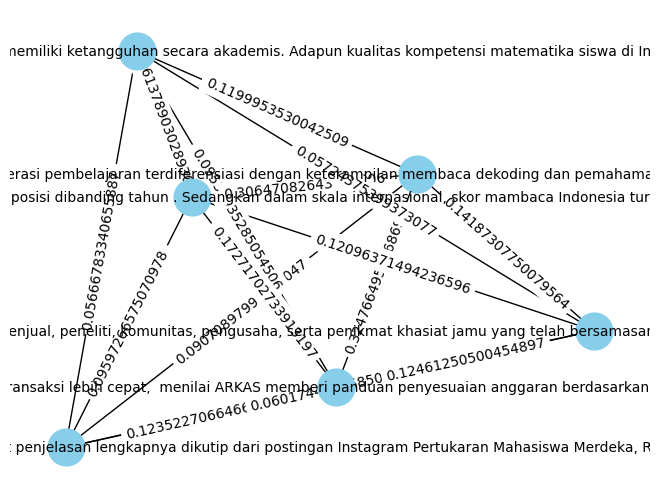

In [18]:
# Menggambar grafik
pos = nx.spring_layout(G)
edge_labels = {(n1, n2): d['weight'] for n1, n2, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [19]:
closeness_centrality = nx.closeness_centrality(G, distance='weight')

sorted_closeness_centrality = {node: value for node, value in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)}

# Membuat DataFrame dari hasil yang diurutkan
df = pd.DataFrame(list(sorted_closeness_centrality.items()), columns=['Node', 'Closeness Centrality'])

# Menampilkan DataFrame
df

,Node,Closeness Centrality
0,Pertukaran Mahasiswa Merdeka PMM memasuki pr...,11.708324
1,Organization for Economic Cooperation and Deve...,10.375235
2,Jamu Indonesia resmi masuk Warisan Budaya Takb...,9.903589
3,Berdasarkan survei Programme for International...,6.858941
4,Aplikasi Rencana Kegiatan dan Anggaran Sekolah...,6.845065
5,Pusdiklat Tenaga Teknis Pendidikan dan Keagama...,6.635782
